# t×q-fold Сross-validation

Обсуждаем способы оценки качества модели и подбора её гиперпараметров.<br>
Следующий ниже вспомогательный блок можно проскролить.

In [1]:
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt      
import seaborn as sn

from sklearn.neighbors       import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.datasets        import make_moons
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

#---------------------------------------------------------------------------------------
    
def plot_data(X, Y, lim=(0.,1.), clf = None, num = 100, prob = True, title=""):                
    """
    Рисуем 2D график примереров вместе с разделяющей линией модели clf (если есть)
    """
    plt.figure (figsize=(4, 4), facecolor ='w')                                 
    
    if clf is not None:   
        x1 = np.linspace(lim[0], lim[1], num, dtype=np.float32)
        x2 = np.linspace(lim[0], lim[1], num, dtype=np.float32)
        x1, x2 =  np.meshgrid(x1, x2)            
        inp = np.c_[x1.ravel(), x2.ravel()]
        if prob:
            prob = clf.predict_proba(inp)[:,1].reshape(x1.shape)
            plt.imshow(prob, extent=[lim[0], lim[1], lim[0], lim[1]],  origin='lower', cmap='bwr', alpha=0.3)
            
            label = clf.predict(inp).reshape(x1.shape) 
            plt.contour(x1, x2, label, cmap='gray')                
        else:        
            label = clf.predict(inp).reshape(x1.shape) 
            plt.contourf(x1, x2, label, alpha=0.3, cmap='bwr')                
    
    plt.scatter(X[:,0], X[:,1], c=Y,  s=5, cmap='bwr')        
    plt.xlim(0, 1)
    plt.ylim(0, 1);
    plt.title(title)
    plt.show()                     

#-------------------------------------------------------------------------------------    

def norm(X):
    """ Нормализация данных в единичный куб [0...1]^n в пространстве признаков"""
    return (X - X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))    

#-------------------------------------------------------------------------------------    

def shuffle_data(X,Y):
    """ Перемешиваем данные """
    idx = np.random.permutation(len(Y)) 
    return X[idx], Y[idx]        

#---------------------------------------------------------------------------------------

def eval_model(clf, X,Y, count=1, cv=5, info=""):
    """ 
    Оцениваем модель по кроссвалидации (t×q-fold cross-validation) с q=cv-фолдами, 
    повторяя эксперимент t=count раз, перемешивая перед эксперииментом данные.
    """
    count = max(1, count)
    cv    = max(2, cv)
    
    tm1 = time.process_time() 
    acc_val, acc_trn, rec_val, rec_trn = np.array([]), np.array([]), np.array([]), np.array([])
    for _ in range(count):
        X, Y = shuffle_data(X,Y)
        
        res = cross_validate(clf, X, Y, cv=cv, return_train_score=True, scoring=['accuracy', 'recall'])            
        
        acc_val = np.concatenate([acc_val, res['test_accuracy']])
        acc_trn = np.concatenate([acc_trn, res['train_accuracy']])    
        rec_val = np.concatenate([rec_val, res['test_recall']])
        rec_trn = np.concatenate([rec_trn, res['train_recall']])
    
    tm2 = time.process_time() 
    
    print(f"({count}×{cv})  val: acc={acc_val.mean():.3f} recall={rec_val.mean():.3f}  acc(trn-val)={acc_trn.mean()-acc_val.mean():.3f};   trn: acc={acc_trn.mean():.3f}  recall={rec_trn.mean():.3f};  {(tm2-tm1)/(cv*count):.2f}s   {info}")    

## Постановка задачи

Между математическим подходом к ML и реальностью естественно существет большая разница.<br> 
Но математика хороша тем, что **иногда** худо-бедно отражает различные аспекты реальности :)

В ML, обычно, мы имеем **тренировочную** (`trn`) и **тестовою** (`tst`) выбоки. На тренировочной нас проверяет заказчик или соревнование kaggle.<br>
В идеале эти выборки получены **случайным** отбором из генеральной совокупности (большого набора) примеров (очень сильное допущение).<br>

По тренировочным данным необходимо построить модель обладающую максимальной точностью на тестовых данных.<br>
Модель может быть **недообученна** или **переобучена**. И в том, и в другом случае это плачевнно сказывается на метрике тестовых данных.

Обычно, из тестовой вборки мы выбираем  **валидационную** подвыбоку `val`.<br>
Она играет разную роль на различных этапах обучения. Её можно использовать для:
<ul>
1) подбора оптимальных гиперпараметров модели;<br> 
2) остановки обучения в нейронных сетях;<br> 
3) варьирования разнообразия обучающих данных при построении ансамбля моделей. 
</ul>
Далее обсужаем аспекты подбора гиперпараметров (только пункт 1).


Главная проблема состоит в том, что тренеровочные данные часто имеют мало примеров. Перед нами возникает делема - выделить  меньше примеров на обучение (построить плохую модель), но надёжнее её оценить по оставшейся валидации или лучше обучить модель, но получить ненадёжную оценку метрик по маленькой валидации. При выборе гиперпараметров колебания в значении метрики могут существенно затруднить их выбор. Однако плохо обучать модель (на малом количестве данных) тоже не есть здорово.

## Истинная модель данных

Далее рассматриваем  синтетические данные в которых  известна "истинная" модель, которая собственно данные и создаёт.<br> Например, в 2-мерном прострастве признаков "генеральная совокупность" датасета **двух лун** с двумя классами (синий и красный) в остутствии шума имеет вид: 

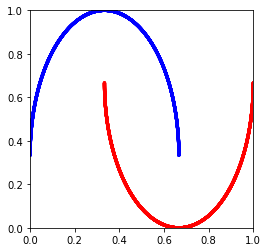

In [2]:
X, Y = make_moons(n_samples=10000, noise=0, random_state=42)  
X = (X - X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
plot_data(X,Y)

Шум размывает эти луны, но "теоретическая" разделяющая классы граница от этого не сильно (?) зависит:

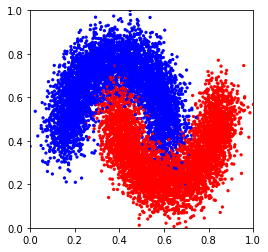

In [3]:
X, Y = make_moons(n_samples=10000, noise=0.2, random_state=42)  
X = norm(X)
plot_data(X,Y)

## Размерность пространства признаков и число тренировочных данных

Чем больше признаков, описывающих объект, тем, вообще говоря, требуется больше  данных чтобы обучить модель.

Для равномерного заполнения квадрата в 2-мерном пространстве признаков необходимо относительно немного точек (примеров).<br> Когда признаков много, для "заполнения" пространства признаков требуется уже экспоненциально больше примеров.
Так, пусть в $n$-мерном случае признаки нормированы на диапазон $[0...1]$ (примеры находятся в $n$-мерном кубе).
Разобъём каждый признак на два интервала (2 дискретных значения). В кубе появится $2^n$ кубиков. Для помещения только **одного** примера в каждый кубик при $n=32$ потребуется $4294967296$ примеров.

Соответственно, надёжность вычисления метрик в  большинстве моделей ML стремительно ухудшается с ростом числа признаков. Впрочем, ситуация облегчается тем, что, обычно, в $n$-мерном пространстве примеры "прижимаются" к более низкомерным поверхностям или имеют простые разделяющие поверхности между классами (типа гиперплоскостей). В этом случае равномерное заполнение пространства признаков не нужно.

## Тренировочные данные

В 2-мерном пространстве признаков (`n = n_features = 2`) сгенерим достаточно мало данных (далее n_samples=100, по 50 на класс). 

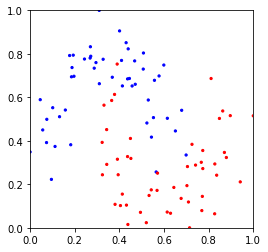

In [4]:
X_trn, Y_trn = make_moons(n_samples=100, noise=0.2, random_state=42)  # тренировочные данные
X_tst, Y_tst = make_moons(n_samples=100, noise=0.2, random_state=43)  # тестовые данные 

X_trn, X_tst = norm(X_trn), norm(X_tst)

plot_data(X_trn,Y_trn)

## Кросс-валидация

В классических методах ML (библиотека `sklearn`), обычно, мы оцениваем модель уже **после** её обучения.<br> 
Это оценивание преследует следующие задачи:
<ul>
<li> выявление переобучения (метрика на trn существенно лучше, чем на val)
<li> подбор гиперпараметров (улучшение val метрики и её сближение с trn)
<li> отбор значимых признаков (опять же улучшающую val)
</ul>
Последние две задачи требуют большого числа экспериментов. При этом необходимо получать достаточно надёжные (воспроизводимые) метрики, иначе выводы по отбору гиперпараметров или признаков будут ошибочными.
    
Для оценки модели в общем случае используется **$t×q$-fold кросс-валидация**. Случайно перемешанные тренировочные данные разбиваются на q=cv непересекающихся, примерно равных частей ("складок"). Одна часть используется для валидации (вычисления метрик), а на остальных q-1 частях модель обучается. Затем берётся вторая часть и т.д. q раз. Эта процедура повторяется t=count раз (каждый раз перед очередным q-разбиением данные перемешиваются). По всем $t*q$ этапам обучение-валидация вычисляются средние метрики (accuracy, recall, precition и т.п.).

Чем больше произведение $t*q$, тем  статистически более **надёжные** получаются метрики. Временные затраты также пропорциональны $t*q$. Хотя, например, $10×5$ будет несколько быстрее, чем $1×50$ (если данных $N=100$, то в первом случае мы 50 раз обучаем на 80 примерах, а во втором - также 50 раз, но на 98 примерах). 

С моей точки зрения валидация $1×50$ предпочтительнее, чем $10×5$. В первом случае мы валидируем каждый раз на новых, не пересекающихся данных. Во втором случае валидационные данные в $t=10$ экспериментах пересекаются. В результате получаются статистически менее надёжные результаты.

## KNeighbors

В качестве примера рассмотрим простейшией метод k-ближайших соседей. Он имеет однин гиперпараметром `n_neighbors` (число ближайших примеров к данной точке пространства и вычисление по ним среднего класса). Кроме этого есть параметр `weights` равный `'uniform'` или `'distance'`. Он определяет веса при вычислении среднего (при `'uniform'` веса одинаковые, при `'distance'` тем больше, чем меньше расстояния; можно также задать свою функцию).

(10×5)  val: acc=0.940 recall=0.928  acc(trn-val)=0.020;   trn: acc=0.960  recall=0.961;  0.00s   k:5, w:uniform
acc_tst: 0.970


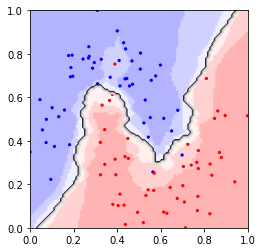

In [5]:
class CFG:        
    n_neighbors = 5          # Def: 5
    weights     = 'uniform'  # Def: 'uniform'

clf = KNeighborsClassifier(n_neighbors = CFG.n_neighbors)

eval_model(clf, X_trn,Y_trn,  count=10, cv=5, info=f"k:{CFG.n_neighbors}, w:{CFG.weights}")  # count × cv fold

clf.fit(X_trn,Y_trn)
print(f"acc_tst: {clf.score(X_tst, Y_tst):.3f}")
plot_data(X_trn, Y_trn, clf = clf)  

При гиперпараметрах по умолчанию и при валидации $10×5$,  мы получаем среднию валидационную точность порядка  0.94, а тренировочную 0.96 (что говорит о небольшом переобучении). При этом тест оказывается существенно лучше (0.97). Но на самом деле нам просто повезло. Если при генерации тестовых данных поменять  `random_state=43` на `44`, то получим падение acc_tst до 0.91

### Волатильность вычисления метрики

Сравним теперь разные способы крос-валидации для вычисления метрик. Чтобы отличия были нагляднее - немного увеличим шум при генерации данных:
`n_samples=100` и `noise=0.3`

Однократная cv=5 (т.е. $1×5$) даёт волатильность метрики порядка 0.03 (acc = ±3%):
```
(1×5)   val: acc=0.850 recall=0.840  acc(trn-val)=0.150;   trn: acc=1.000  recall=1.000;  0.01s   n_neighbors:1
(1×5)   val: acc=0.810 recall=0.760  acc(trn-val)=0.190;   trn: acc=1.000  recall=1.000;  0.01s   n_neighbors:1
(1×5)   val: acc=0.870 recall=0.880  acc(trn-val)=0.130;   trn: acc=1.000  recall=1.000;  0.01s   n_neighbors:1
(1×5)   val: acc=0.810 recall=0.800  acc(trn-val)=0.190;   trn: acc=1.000  recall=1.000;  0.01s   n_neighbors:1
(1×5)   val: acc=0.840 recall=0.820  acc(trn-val)=0.160;   trn: acc=1.000  recall=1.000;  0.01s   n_neighbors:1
```
При борьбе за проценты в точности это очень много. При выборе гиперпараметров нужна более стабильная статистика.
Повтор 10 раз  cv=5, т.е. $t×q$ крос-валидация $10×5$  уменьшает болтанку до ~0.003 (acc = ±0.3%)
```
(10×5)  val: acc=0.830 recall=0.800  acc(trn-val)=0.170;   trn: acc=1.000  recall=1.000;  0.01s   n_neighbors:1
(10×5)  val: acc=0.833 recall=0.818  acc(trn-val)=0.167;   trn: acc=1.000  recall=1.000;  0.00s   n_neighbors:1
(10×5)  val: acc=0.827 recall=0.812  acc(trn-val)=0.173;   trn: acc=1.000  recall=1.000;  0.01s   n_neighbors:1
(10×5)  val: acc=0.826 recall=0.800  acc(trn-val)=0.174;   trn: acc=1.000  recall=1.000;  0.01s   n_neighbors:1
(10×5)  val: acc=0.838 recall=0.816  acc(trn-val)=0.162;   trn: acc=1.000  recall=1.000;  0.01s   n_neighbors:1
```
**Тоже** число обучений c ($1×50$) даёт стабильную метрику с **редким** выбросом (0.840) (?)
```
(1×50)  val: acc=0.830 recall=0.800  acc(trn-val)=0.170;   trn: acc=1.000  recall=1.000;  0.01s   n_neighbors:1
(1×50)  val: acc=0.830 recall=0.800  acc(trn-val)=0.170;   trn: acc=1.000  recall=1.000;  0.01s   n_neighbors:1
(1×50)  val: acc=0.830 recall=0.800  acc(trn-val)=0.170;   trn: acc=1.000  recall=1.000;  0.00s   n_neighbors:1
(1×50)  val: acc=0.830 recall=0.800  acc(trn-val)=0.170;   trn: acc=1.000  recall=1.000;  0.01s   n_neighbors:1
(1×50)  val: acc=0.840 recall=0.820  acc(trn-val)=0.160;   trn: acc=1.000  recall=1.000;  0.00s   n_neighbors:1
```

### Подбор гиперпараметров

На этом "бесконечном" датасете можно проверить методику подбора гиперпараметра по при тестировании $1×50$.
Тестировать будем на большом числе тестовых данных, полученных при разных случайных выборках (`random_state`).

```
acc_val=0.890   acc_(trn-val)=0.048   acc_tst: 0.877 ± 0.019    k:  2, w:uniform
acc_val=0.912   acc_(trn-val)=0.022   acc_tst: 0.899 ± 0.014    k:  5, w:uniform
acc_val=0.912   acc_(trn-val)=0.013   acc_tst: 0.901 ± 0.014    k: 10, w:uniform
acc_val=0.912   acc_(trn-val)=0.004   acc_tst: 0.898 ± 0.013    k: 50, w:uniform
acc_val=0.890   acc_(trn-val)=0.006   acc_tst: 0.887 ± 0.013    k:100, w:uniform
```
На самом деле датасет "две луны" дмалочуствителен к гиперпараметру метода KNeighbors. Существует большое плато 2- 50, где валидационная метрика не меняется, а разница тренировочной и валидационной точностьи плавно снижается (что хорошор).

(1×50)  val: acc=0.912 recall=0.884  acc(trn-val)=0.008;   trn: acc=0.920  recall=0.899;  0.01s   k:20, w:uniform
acc_tst: 0.901 ± 0.013


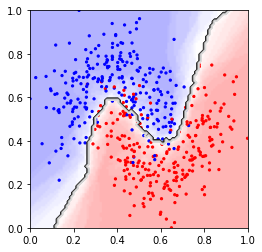

In [6]:
X_trn, Y_trn = make_moons(n_samples=500, noise=0.3, random_state=42)  # тренировочные данные
X_trn = norm(X_trn)

class CFG:        
    n_neighbors = 20           # Def: 5
    weights     = 'uniform'  # Def: 'uniform'

clf = KNeighborsClassifier(n_neighbors = CFG.n_neighbors)

eval_model(clf, X_trn,Y_trn,  count=1, cv=50, info=f"k:{CFG.n_neighbors}, w:{CFG.weights}")  # count × cv fold


clf.fit(X_trn, Y_trn)

scores = []
for state in range(100):
    X_tst, Y_tst = make_moons(n_samples=500, noise=0.3, random_state=state)  # новые тестовые данные 
    X_tst = norm(X_tst)
    scores.append( clf.score(X_tst, Y_tst) )
    
print(f"acc_tst: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
plot_data(X_trn, Y_trn, clf = clf)  

## DecisionTree

Рассмотрим ешё деревья решений. Они лучше других методов, когда расстояние между точками в прострастве прихнаков особого смысла не имеет (разделение всегда идёт только по одному признаку). Деревья также не требуют масштабирования или центрирования признаков.

Чем глубже дерево, тем может оказаться более переобученным. Борьба с этим - ограничение его глубины (`max_depth`) и/или увеличения числа примеров на финальных листьях (`min_samples_leaf`) или промежуточных узлах (`min_samples_split`). Как и в k-ближайших соседях эти праметры, вообще говоря, зависят от размера тренировочной выборки (!).

Метод чувствительнее к гиперпараметрам и использование их по умолчанию (первый експеримент, далеко от оптимального):
```
acc_val=0.858   acc_(trn-val)=0.142   acc_tst: 0.883 ± 0.019    leaf: 1, split:2, depth:None
acc_val=0.900   acc_(trn-val)=0.039   acc_tst: 0.895 ± 0.015    leaf:10, split:2, depth:None
```
Этот метод приводт также с большей волотильности метрик и особой разницы между `(10×5)` и `(1×50)` нет:
```
(10×5)  val: acc=0.900, 0.894, 0.893, 0.895, 0.893, 0.892, 0.895
(1×50)  val: acc=0.900, 0.890, 0.904, 0.894, 0.894, 0.896, 0.892
```

(1×50)  val: acc=0.892 recall=0.892  acc(trn-val)=0.047;   trn: acc=0.939  recall=0.942;  0.00s   leaf:10, split:2, depth:None
depth:7
acc_tst: 0.895 ± 0.015


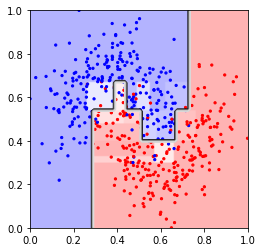

In [7]:
from sklearn.tree import DecisionTreeClassifier

class CFG:        
    min_samples_leaf = 10       # Def:1
    min_samples_split= 2       # Def:2
    max_depth        = None    # Def:None

clf = DecisionTreeClassifier(max_depth=CFG.max_depth, min_samples_split=CFG.min_samples_split, min_samples_leaf=CFG.min_samples_leaf)

eval_model(clf, X_trn,Y_trn,  count=1, cv=50, info=f"leaf:{CFG.min_samples_leaf}, split:{CFG.min_samples_split}, depth:{CFG.max_depth}")  # count × cv fold

clf.fit(X_trn, Y_trn)
print(f"depth:{clf.get_depth()}")

scores = []
for state in range(100):
    X_tst, Y_tst = make_moons(n_samples=500, noise=0.3, random_state=state)  # новые тестовые данные 
    X_tst = norm(X_tst)
    scores.append( clf.score(X_tst, Y_tst) )
    
print(f"acc_tst: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
plot_data(X_trn, Y_trn, clf = clf)  